In [20]:
"""This script serves as a simple example and test for the DNN"""
import configparser
import itertools
import random
import sys

import numpy as np
import triplet
from chainer import Chain, serializers
from chainer import cuda
from chainer import functions as F
from chainer import links as L
from chainer import optimizers, report, training
from chainer.datasets import get_mnist
from chainer.training import extensions
from triplet_iterator import TripletIterator


class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__(
            # the size of the inputs to each layer will be inferred
            l1=L.Linear(None, n_units),  # n_in -> n_units
            l2=L.Linear(None, n_units),  # n_units -> n_units
            l3=L.Linear(None, n_out),  # n_units -> n_out
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y


class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__(predictor=predictor)

    def __call__(self, x_a, x_p, x_n):
        y_a, y_p, y_n = (self.predictor(x) for x in (x_a, x_p, x_n))
        loss = F.triplet(y_a, y_p, y_n)
        report({'loss': loss}, self)
        return loss


def get_trainer(updater, evaluator, epochs):
    trainer = training.Trainer(updater, (epochs, 'epoch'), out='result')
    trainer.extend(evaluator)
    # TODO: reduce LR -- how to update every X epochs?
    # trainer.extend(extensions.ExponentialShift('lr', 0.1, target=lr*0.0001))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.ProgressBar(
        (epochs, 'epoch'), update_interval=10))
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss']))
    return trainer

def generate_triplet_part(dataset, negative):
    triplet_part = []
    for i in range(0, 10):
        for j in range(0, int(len(dataset) / 30)):
            while True:
                sample_idx = random.randint(0, len(dataset) - 1)
                sample = dataset[sample_idx]
                if negative: 
                    if sample[1] != i:
                        triplet_part.append(sample) 
                        break
                else: 
                    if sample[1] == i:
                        triplet_part.append(sample) 
                        break
    return triplet_part

def generate_triplet(dataset):
    anchors = generate_triplet_part(dataset, False)
    positives = generate_triplet_part(dataset, False)
    negatives = generate_triplet_part(dataset, True)
            
    iters = [iter(anchors), iter(positives), iter(negatives)]
    merged = list(next(it) for it in itertools.cycle(iters))

    return zip(*merged)
    

config = configparser.ConfigParser()
config.read('mnist.conf')

batch_size = int(config['TRAINING']['batch_size'])
epochs = int(config['TRAINING']['epochs'])
lr = float(config['TRAINING']['lr'])
lr_interval = int(config['TRAINING']['lr_interval'])
gpu = int(config['TRAINING']['gpu'])

xp = cuda.cupy if gpu >= 0 else np

train, test = get_mnist(withlabel=True)

train_merged, train_labels = generate_triplet(train)
assert not [i for (i, label) in enumerate(train_labels[0::3]) if label == train_labels[i * 3 + 2] ]
print("Train Done")

test_merged, test_labels = generate_triplet(test)
assert not [i for (i, label) in enumerate(test_labels[0::3]) if label == test_labels[i * 3 + 2] ]

print("Test Done")

/home/hendraet/stud_sync/Studium/master/ma/experiments/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: generator 'generate_triplet.<locals>.<genexpr>' raised StopIteration


Train Done
Test Done


### Train and Save Model

In [21]:
train_iter = TripletIterator(train_merged,
                             batch_size=batch_size,
                             repeat=True,
                             xp=xp)
test_iter = TripletIterator(test_merged,
                            batch_size=batch_size,
                            xp=xp)
base_model = MLP(1024, 10)
model = Classifier(base_model)

if gpu >= 0:
    cuda.get_device(gpu).use()
    model.to_gpu()

optimizer = optimizers.SGD(lr=lr)
optimizer.setup(model)
updater = triplet.Updater(train_iter, optimizer)

evaluator = triplet.Evaluator(test_iter, model)

trainer = get_trainer(updater, evaluator, epochs)
trainer.run()

serializers.save_npz('full_model.npz', model)
serializers.save_npz('embeddings.npz', base_model)


epoch       main/loss   validation/main/loss
     total [..................................................]  0.75%
this epoch [#######...........................................] 15.00%
        10 iter, 0 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  1.50%
this epoch [###############...................................] 30.00%
        20 iter, 0 epoch / 20 epochs
    3.4653 iters/sec. Estimated time to finish: 0:06:18.994266.
     total [#.................................................]  2.25%
this epoch [######################............................] 45.00%
        30 iter, 0 epoch / 20 epochs
    3.5366 iters/sec. Estimated time to finish: 0:06:08.526494.
     total [#.................................................]  3.00%
this epoch [##############################....................] 60.00%
        40 iter, 0 epoch / 20 epochs
     3.635 iters/sec. Estimated time to finish: 0:05:5

### Create Embeddings

In [22]:
# base_model = MLP(100, 10)
# serializers.load_npz('embeddings.npz', base_model)

embeddings = []

for img in test_merged:
    embedding = base_model(np.reshape(img, (1, 784)))
    embedding_flat = np.squeeze(embedding.array)
    embeddings.append(embedding_flat)
print("Done")

Done


### PCA

In [23]:
from sklearn.decomposition import PCA

X = np.array(embeddings)
pca = PCA(n_components=2)
fitted_data = pca.fit_transform(X)
pass

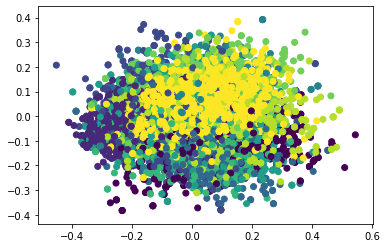

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(fitted_data[:, 0], fitted_data[:, 1], c=test_labels)
plt.show()
